In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Dataset dan Dataloader

In [3]:
bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor() 
])


train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

In [4]:
train_set

Dataset ImageFolder
    Number of datapoints: 40000
    Root location: data/train/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [6]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 1, 28, 28])

In [7]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur & Config

In [10]:
from jcopdl.layers import linear_block

In [11]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2): # kasih org input biar keren...config itu sbnrnya ini
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation="lsoftmax")
        )
        
    def forward(self, x):
        return self.fc(x)

In [12]:
config = set_config({
    "input_size" : 784,
    "n1" : 256,
    "n2" : 64,
    "output_size" : len(train_set.classes),
    "dropout" : 0.2
})

# Training preparation --> MCO

In [14]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [15]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval() 
    cost = correct = 0 
    for feature, target in tqdm(dataloader, desc=mode.title()): 
        feature, target = feature.to(device), target.to(device)
        output = model(feature) 
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward() 
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 0.7420 | Test_cost  = 0.4851 | Train_score = 0.7369 | Test_score = 0.8185 |




Epoch     2
Train_cost  = 0.4755 | Test_cost  = 0.4227 | Train_score = 0.8341 | Test_score = 0.8425 |




Epoch     3
Train_cost  = 0.4202 | Test_cost  = 0.3813 | Train_score = 0.8526 | Test_score = 0.8615 |




Epoch     4
Train_cost  = 0.3910 | Test_cost  = 0.3625 | Train_score = 0.8614 | Test_score = 0.8658 |




Epoch     5
Train_cost  = 0.3704 | Test_cost  = 0.3438 | Train_score = 0.8677 | Test_score = 0.8748 |




Epoch     6
Train_cost  = 0.3522 | Test_cost  = 0.3370 | Train_score = 0.8739 | Test_score = 0.8740 |
==> EarlyStop patience =  1 | Best test_score: 0.8748




Epoch     7
Train_cost  = 0.3363 | Test_cost  = 0.3281 | Train_score = 0.8785 | Test_score = 0.8811 |




Epoch     8
Train_cost  = 0.3285 | Test_cost  = 0.3293 | Train_score = 0.8815 | Test_score = 0.8785 |
==> EarlyStop patience =  1 | Best test_score: 0.8811




Epoch     9
Train_cost  = 0.3150 | Test_cost  = 0.3163 | Train_score = 0.8864 | Test_score = 0.8828 |




Epoch    10
Train_cost  = 0.3077 | Test_cost  = 0.3360 | Train_score = 0.8886 | Test_score = 0.8766 |
==> EarlyStop patience =  1 | Best test_score: 0.8828




Epoch    11
Train_cost  = 0.2999 | Test_cost  = 0.3143 | Train_score = 0.8912 | Test_score = 0.8867 |




Epoch    12
Train_cost  = 0.2893 | Test_cost  = 0.3133 | Train_score = 0.8939 | Test_score = 0.8875 |




Epoch    13
Train_cost  = 0.2861 | Test_cost  = 0.3092 | Train_score = 0.8961 | Test_score = 0.8878 |




Epoch    14
Train_cost  = 0.2815 | Test_cost  = 0.3146 | Train_score = 0.8976 | Test_score = 0.8864 |
==> EarlyStop patience =  1 | Best test_score: 0.8878




Epoch    15
Train_cost  = 0.2706 | Test_cost  = 0.3129 | Train_score = 0.9016 | Test_score = 0.8855 |
==> EarlyStop patience =  2 | Best test_score: 0.8878




Epoch    16
Train_cost  = 0.2658 | Test_cost  = 0.3035 | Train_score = 0.9030 | Test_score = 0.8891 |




Epoch    17
Train_cost  = 0.2628 | Test_cost  = 0.3051 | Train_score = 0.9030 | Test_score = 0.8892 |




Epoch    18
Train_cost  = 0.2584 | Test_cost  = 0.3172 | Train_score = 0.9031 | Test_score = 0.8867 |
==> EarlyStop patience =  1 | Best test_score: 0.8892




Epoch    19
Train_cost  = 0.2531 | Test_cost  = 0.3042 | Train_score = 0.9054 | Test_score = 0.8888 |
==> EarlyStop patience =  2 | Best test_score: 0.8892




Epoch    20
Train_cost  = 0.2460 | Test_cost  = 0.3122 | Train_score = 0.9087 | Test_score = 0.8902 |


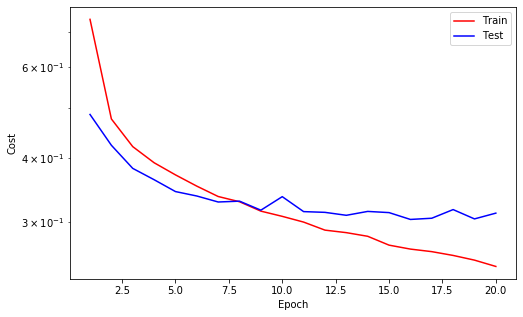

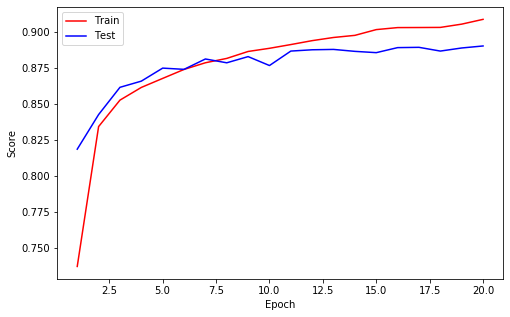



Epoch    21
Train_cost  = 0.2465 | Test_cost  = 0.3271 | Train_score = 0.9078 | Test_score = 0.8788 |
==> EarlyStop patience =  1 | Best test_score: 0.8902




Epoch    22
Train_cost  = 0.2414 | Test_cost  = 0.3036 | Train_score = 0.9108 | Test_score = 0.8927 |




Epoch    23
Train_cost  = 0.2356 | Test_cost  = 0.3002 | Train_score = 0.9118 | Test_score = 0.8933 |




Epoch    24
Train_cost  = 0.2305 | Test_cost  = 0.3228 | Train_score = 0.9149 | Test_score = 0.8868 |
==> EarlyStop patience =  1 | Best test_score: 0.8933




Epoch    25
Train_cost  = 0.2286 | Test_cost  = 0.3093 | Train_score = 0.9144 | Test_score = 0.8898 |
==> EarlyStop patience =  2 | Best test_score: 0.8933




Epoch    26
Train_cost  = 0.2218 | Test_cost  = 0.3112 | Train_score = 0.9170 | Test_score = 0.8887 |
==> EarlyStop patience =  3 | Best test_score: 0.8933




Epoch    27
Train_cost  = 0.2249 | Test_cost  = 0.3068 | Train_score = 0.9155 | Test_score = 0.8940 |




Epoch    28
Train_cost  = 0.2192 | Test_cost  = 0.3090 | Train_score = 0.9183 | Test_score = 0.8901 |
==> EarlyStop patience =  1 | Best test_score: 0.8940




Epoch    29
Train_cost  = 0.2143 | Test_cost  = 0.3140 | Train_score = 0.9186 | Test_score = 0.8922 |
==> EarlyStop patience =  2 | Best test_score: 0.8940




Epoch    30
Train_cost  = 0.2105 | Test_cost  = 0.3112 | Train_score = 0.9226 | Test_score = 0.8921 |
==> EarlyStop patience =  3 | Best test_score: 0.8940




Epoch    31
Train_cost  = 0.2116 | Test_cost  = 0.3127 | Train_score = 0.9212 | Test_score = 0.8911 |
==> EarlyStop patience =  4 | Best test_score: 0.8940




Epoch    32
Train_cost  = 0.2059 | Test_cost  = 0.3005 | Train_score = 0.9233 | Test_score = 0.8954 |




Epoch    33
Train_cost  = 0.2028 | Test_cost  = 0.3181 | Train_score = 0.9236 | Test_score = 0.8928 |
==> EarlyStop patience =  1 | Best test_score: 0.8954




Epoch    34
Train_cost  = 0.2022 | Test_cost  = 0.3176 | Train_score = 0.9237 | Test_score = 0.8919 |
==> EarlyStop patience =  2 | Best test_score: 0.8954




Epoch    35
Train_cost  = 0.1963 | Test_cost  = 0.3175 | Train_score = 0.9257 | Test_score = 0.8920 |
==> EarlyStop patience =  3 | Best test_score: 0.8954




Epoch    36
Train_cost  = 0.1984 | Test_cost  = 0.3146 | Train_score = 0.9243 | Test_score = 0.8925 |
==> EarlyStop patience =  4 | Best test_score: 0.8954




Epoch    37
Train_cost  = 0.1920 | Test_cost  = 0.3148 | Train_score = 0.9275 | Test_score = 0.8955 |




Epoch    38
Train_cost  = 0.1899 | Test_cost  = 0.3192 | Train_score = 0.9284 | Test_score = 0.8945 |
==> EarlyStop patience =  1 | Best test_score: 0.8955




Epoch    39
Train_cost  = 0.1895 | Test_cost  = 0.3324 | Train_score = 0.9293 | Test_score = 0.8939 |
==> EarlyStop patience =  2 | Best test_score: 0.8955




Epoch    40
Train_cost  = 0.1829 | Test_cost  = 0.3407 | Train_score = 0.9305 | Test_score = 0.8879 |


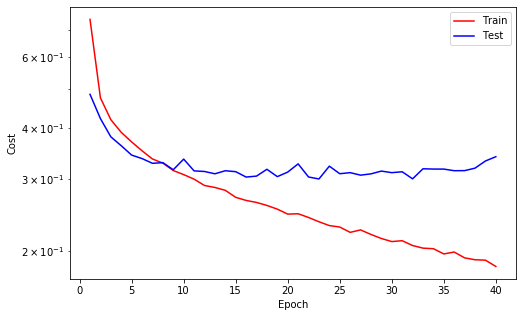

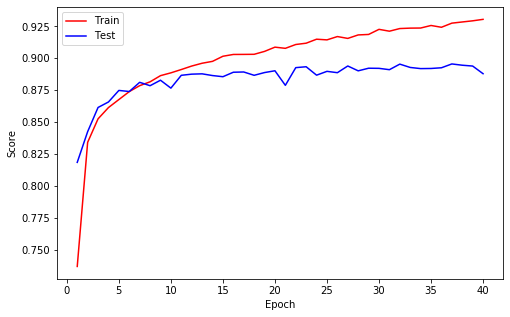

==> EarlyStop patience =  3 | Best test_score: 0.8955




Epoch    41
Train_cost  = 0.1834 | Test_cost  = 0.3211 | Train_score = 0.9306 | Test_score = 0.8941 |
==> EarlyStop patience =  4 | Best test_score: 0.8955




Epoch    42
Train_cost  = 0.1810 | Test_cost  = 0.3232 | Train_score = 0.9313 | Test_score = 0.8959 |




Epoch    43
Train_cost  = 0.1845 | Test_cost  = 0.3349 | Train_score = 0.9299 | Test_score = 0.8963 |




Epoch    44
Train_cost  = 0.1773 | Test_cost  = 0.3314 | Train_score = 0.9327 | Test_score = 0.8943 |
==> EarlyStop patience =  1 | Best test_score: 0.8963




Epoch    45
Train_cost  = 0.1780 | Test_cost  = 0.3490 | Train_score = 0.9316 | Test_score = 0.8912 |
==> EarlyStop patience =  2 | Best test_score: 0.8963




Epoch    46
Train_cost  = 0.1726 | Test_cost  = 0.3309 | Train_score = 0.9353 | Test_score = 0.8939 |
==> EarlyStop patience =  3 | Best test_score: 0.8963




Epoch    47
Train_cost  = 0.1723 | Test_cost  = 0.3308 | Train_score = 0.9344 | Test_score = 0.8924 |
==> EarlyStop patience =  4 | Best test_score: 0.8963




Epoch    48
Train_cost  = 0.1676 | Test_cost  = 0.3322 | Train_score = 0.9374 | Test_score = 0.8942 |
==> EarlyStop patience =  5 | Best test_score: 0.8963
==> Execute Early Stopping at epoch: 48 | Best test_score: 0.8963
==> Best model is saved at model


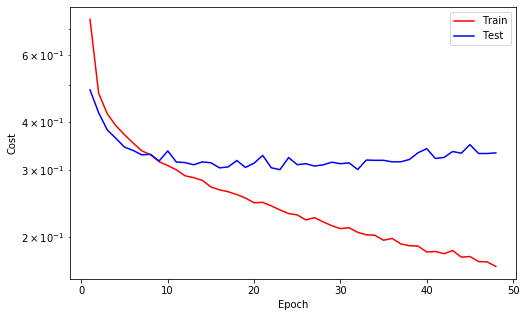

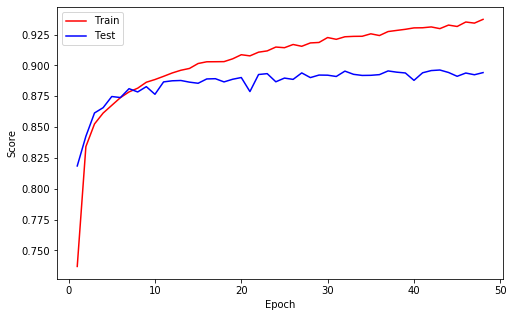

In [16]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
         test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
         
    # Logging and Reporting
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break
    

In [20]:
model

FashionClassifier(
  (fc): Sequential(
    (0): Flatten()
    (1): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=10, bias=True)
      (1): LogSoftmax()
    )
  )
)

# Prediksi

In [23]:
feature , target = next(iter(testloader))
feature , target = feature.to(device), target.to(device)

In [24]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]

['Trouser',
 'Bag',
 'T-shirt or Top',
 'Sandal',
 'Shirt',
 'Sandal',
 'Coat',
 'Sneaker',
 'Pullover',
 'Ankle boot',
 'Coat',
 'Pullover',
 'Sneaker',
 'T-shirt or Top',
 'Trouser',
 'T-shirt or Top',
 'T-shirt or Top',
 'Bag',
 'Shirt',
 'Pullover',
 'Shirt',
 'Sneaker',
 'Sandal',
 'Shirt',
 'Bag',
 'Dress',
 'Pullover',
 'T-shirt or Top',
 'Dress',
 'Dress',
 'Pullover',
 'T-shirt or Top',
 'Sandal',
 'Ankle boot',
 'Bag',
 'Ankle boot',
 'Sandal',
 'Sneaker',
 'Shirt',
 'Pullover',
 'Coat',
 'T-shirt or Top',
 'Trouser',
 'Shirt',
 'Coat',
 'Trouser',
 'Trouser',
 'T-shirt or Top',
 'Ankle boot',
 'Pullover',
 'Coat',
 'Coat',
 'Ankle boot',
 'Sneaker',
 'Sandal',
 'Sandal',
 'T-shirt or Top',
 'Sneaker',
 'Ankle boot',
 'Shirt',
 'Sandal',
 'Shirt',
 'Sandal',
 'Sandal',
 'T-shirt or Top',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Shirt',
 'Sandal',
 'Shirt',
 'Dress',
 'T-shirt or Top',
 'Dress',
 'Trouser',
 'T-shirt or Top',
 'T-shirt or Top',
 'Sandal',
 'T-shirt or Top',
 'Sh

In [25]:
import matplotlib.pyplot as plt

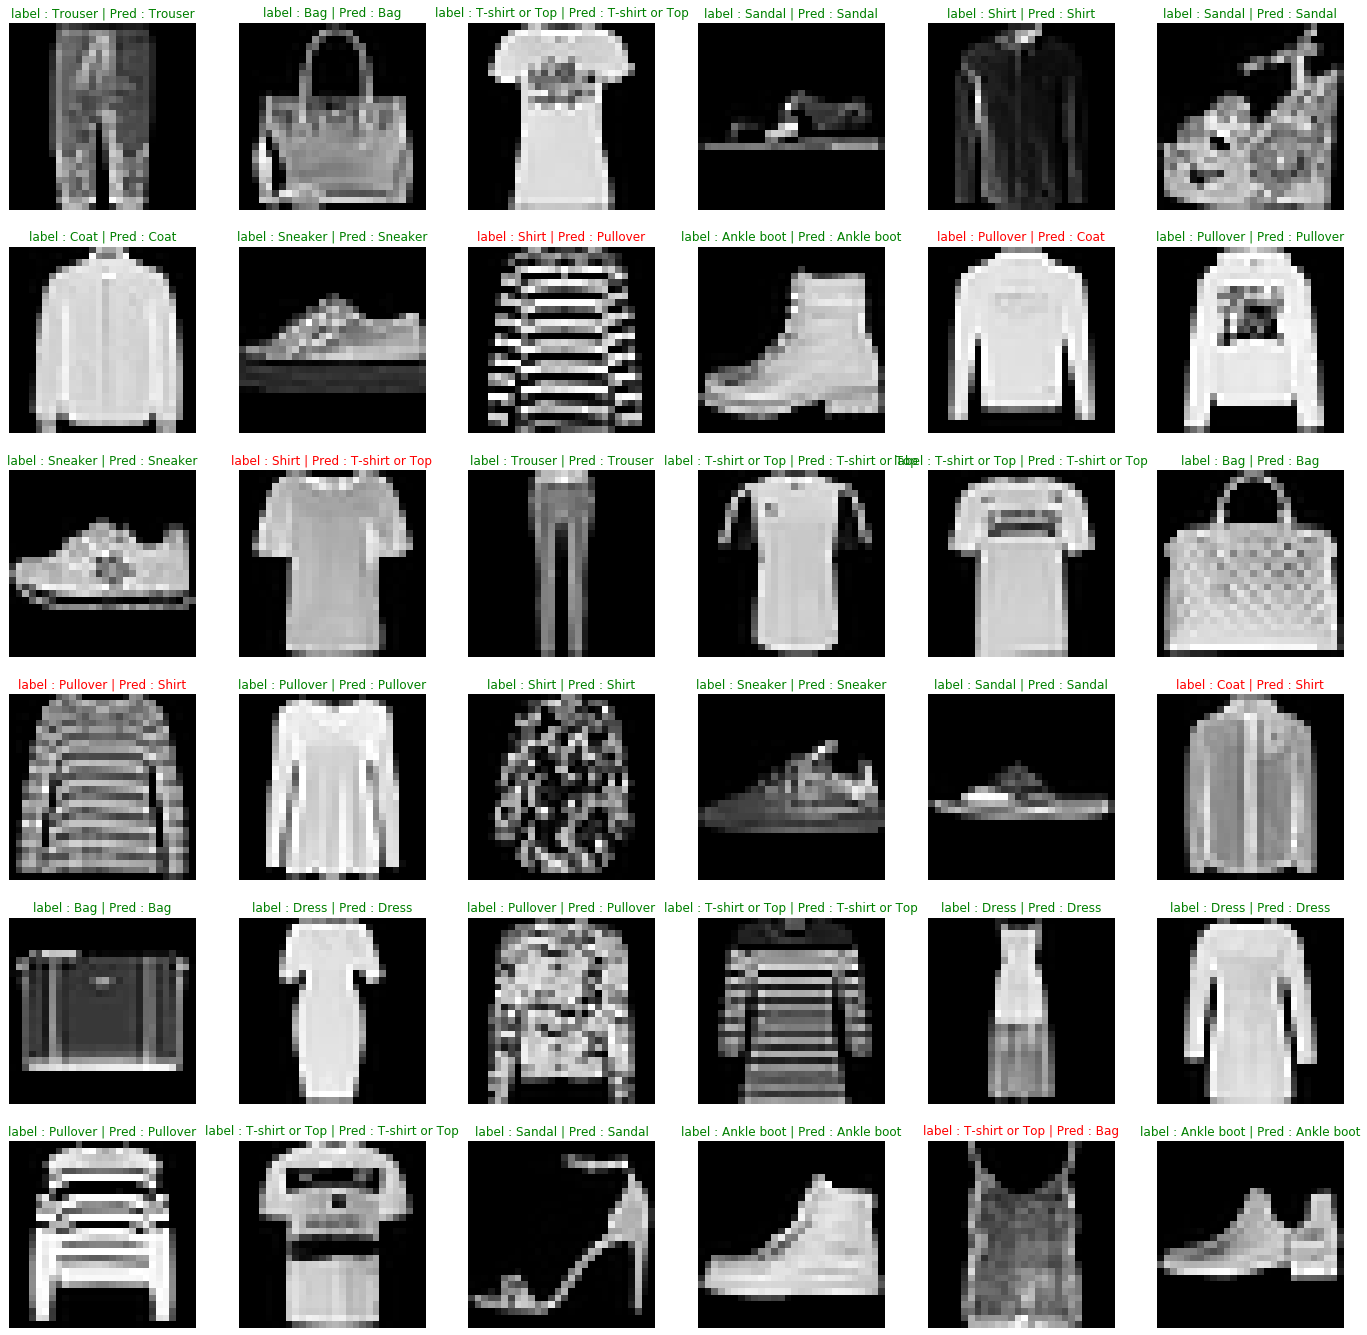

In [30]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28, 28).cpu(), cmap="gray")
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"label : {label} | Pred : {pred}", fontdict=font)
    ax.axis("off")